In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/New_MOACOR/')
cwd= os.getcwd()

%run moacor_functions
%run DissimilarityMatrix_drive
%run ReduceCardinality_drive

In [ ]:
pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=3f661e6fd2da85b2181e4843654e76c87e8568cec7409417874f123c10cb77f7
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

from IPython.display import clear_output
from mpl_toolkits.mplot3d import axes3d
from pandas.plotting import parallel_coordinates


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from time import sleep

#### Plot Functions

In [ ]:
# Plot the points in 3 dimensions.
def plot_3d(points, title):
    x, y, z = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_zlabel("f3")
    ax.set_title(title)
    ax.view_init(45, 45, 0)
    plt.show()

# Plot the points in 3 dimensions.
def plot_2d(points, title):
    x, y = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_title(title)
    plt.show()

# Plot the parallel coordinates.
def parallel_plot(points,title):
    final_evals_df = pd.DataFrame(points)
    final_evals_df['Color'] = 1
    plt.figure(figsize=(4, 2))
    parallel_coordinates(final_evals_df,'Color', colormap='viridis', linewidth=1)
    plt.title(title)
    plt.xlabel('Objective')
    plt.ylabel('Evaluation')
    plt.show()

#### Generate Initial Population

In [ ]:
def initial_solutions(problem, n_initial, n_vars):
    mop_data = mop_data_func(n_vars, problem)
    init_sols = np.zeros((n_initial,n_vars))
    for i in range(n_initial):
        init_sols[i] = random_solution(mop_data)
    return init_sols

#### Evaluate Population

In [ ]:
def evaluate_function(problem, sols_to_eval, n_funcs, n_vars, inverted_flag):
    if ("DTLZ" in problem):
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    elif ("WFG" in problem):
        k_var = ( n_funcs - 1 ) * 2
        if n_funcs < 3:
            k_var = 4
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs, k=k_var)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    else:
        evaluations = evaluate_solutions(sols_to_eval, n_funcs, problem, n_vars)
    if (inverted_flag):
        evaluations = -1 * evaluations
    return evaluations

#### Rank Population

Normalize

In [ ]:
def nadir_func(matrix):
    num_cols = len(matrix[0])
    max_vals = [-float('inf')] * num_cols
    for col_idx in range(num_cols):
        for row_idx in range(len(matrix)):
            if matrix[row_idx][col_idx] > max_vals[col_idx]:
                max_vals[col_idx] = matrix[row_idx][col_idx]
    return max_vals

def ideal_func(matrix):
    num_cols = len(matrix[0])
    min_vals = [float('inf')] * num_cols
    for col_idx in range(num_cols):
        for row_idx in range(len(matrix)):
            if matrix[row_idx][col_idx] < min_vals[col_idx]:
                min_vals[col_idx] = matrix[row_idx][col_idx]
    return min_vals

def normalize(archive, ideal, nadir):
    normalized_archive = archive.copy()
    n_funcs = archive.shape[1]
    count = 0
    for p in archive:
        for i in range(n_funcs):
            if nadir[i] == ideal[i]:
                a = (p[i]-ideal[i])/(0.000001)
            else:
                a = (p[i]-ideal[i])/(nadir[i]-ideal[i])
            normalized_archive[count,i] = a
        count = count + 1
    return normalized_archive


def threshold_of_every_variable(std_threshold, n_vars, problem):
    mop_data = mop_data_func(n_vars, problem)
    lower = []
    upper = []
    variable_threshold = []

    for i in range(n_vars):
        lower.append(mop_data[i*2])
        upper.append(mop_data[i*2 + 1])

    for i in range(n_vars):
        variable_threshold.append((upper[i] - lower[i]) * std_threshold)

    return variable_threshold

Weights (ACOR)

In [ ]:
# Not in ACOR
def normalize_array_from1_to50(arr):
    min_val = min(arr)
    max_val = max(arr)
    normalized_array = [1 + ((x - min_val) / (max_val - min_val)) * 49 for x in arr]
    return normalized_array

# As in ACOR
def selection_weights(q, k):
    ranking_array = np.empty([1])
    array_to_normalize = list(range(1, k+1))
    normalized_array = normalize_array_from1_to50(array_to_normalize)
    part1 = 1 / ( q * 50 * ( 2 * np.pi) ** 0.5)
    for i in normalized_array:
        part2 = np.exp( - ( ((i)**2) / (2 * q**2 * k**2) ) )
        weight = part1*part2
        ranking_array = np.vstack((ranking_array,weight))
    ranking_array = np.delete(ranking_array,0,0)
    return ranking_array

Non Domination Ranking

In [ ]:
def dominates(point, points):
    index = np.where(np.all(point == points,axis=1))[0]
    points = np.delete(points,index,0)
    non_dominated = np.any(np.all(points <= point, axis=1))
    return not non_dominated

def non_dominated_solutions_func(archive, n_vars, n_funcs):
    size = archive.shape[1]
    non_dominated_solutions = np.empty([size])
    for solution in archive:
        if (dominates(solution[n_vars:n_funcs+n_vars],archive[:,n_vars:n_funcs+n_vars])):
            non_dominated_solutions = np.vstack((non_dominated_solutions,solution))
    non_dominated_solutions = np.delete(non_dominated_solutions,0,0)
    return non_dominated_solutions

def layered_array(solutions, evaluations, n_vars, n_funcs, n_initial):
    archive = np.concatenate((solutions, evaluations), axis=1)
    layers = np.empty([1])
    result_array = archive
    archive = np.empty([archive.shape[1]])
    layer = 1

    while layers.shape[0] < n_initial+1:
        layer_solutions = non_dominated_solutions_func(result_array,n_vars,n_funcs)
        mask = np.isin(result_array,layer_solutions)
        result_array = result_array[~np.all(mask, axis=1)]
        archive = np.vstack((archive,layer_solutions))
        for i in range(len(layer_solutions)):
            layers = np.vstack((layers,layer))
        layer = layer + 1

        if result_array.shape[0] == 0:
            break

    layers = np.delete(layers,0,0)
    archive = np.delete(archive,0,0)
    solutions = archive[:,:n_vars]
    evaluations = archive[:,n_vars:n_funcs+n_vars]
    return solutions, evaluations, layers

IGD Sorting / Pair Potential Sorting.
I am using pair potential sorting.

In [ ]:
def igd_plus_contributions_heuristic(A, i, ind, indicator_A):
    A_no_a = np.delete(A,i, axis=0)
    contribution =  indicator_A - ind(A_no_a)
    #contribution =  ind(A_no_a)
    return contribution

def inclusion_IGD_plus(A, keep_k, n_funcs, ind):
    sorted_norm_evals = np.zeros((keep_k,n_funcs))
    for j in range(keep_k):
        contribution = []
        indicator_A = ind(A)
        for i in range(A.shape[0]):
            contrib = igd_plus_contributions_heuristic(A, i, ind, indicator_A)
            contribution.append(contrib)
        index = np.where(contribution == min(contribution))[0]
        sorted_norm_evals[j] = A[index[0]]
        A = np.delete(A,index[0],0)
    return sorted_norm_evals

# Using the Pair Potential Functions To Sort.
def PPF_sorting(solutions, evaluations, layers, NDS, n_initial, n_vars, n_funcs):
    NDS_evaluations = NDS[:,n_vars:n_funcs+n_vars]
    total_evaluations = np.concatenate((evaluations, NDS_evaluations))
    ideal = ideal_func(total_evaluations)
    nadir = nadir_func(total_evaluations)
    norm_evals = normalize(evaluations, ideal, nadir)
    ref_set = normalize(NDS_evaluations, ideal, nadir)
    ref_set = ref_set - 0.2

    ind = IGDPlus(ref_set)

    archive = np.concatenate((solutions, evaluations),axis=1)
    archive = np.concatenate((archive, norm_evals),axis=1)

    all_sorted_norm_evals = np.zeros((n_initial,n_funcs))

    counts = np.bincount(layers.flatten().astype(int))
    counts = np.delete(counts,0)
    #print('Layer count: ', counts)

    counter = 0
    for layer_count in counts:
        layer_norm_evals = norm_evals[counter:counter+layer_count,:]
        if (counter + layer_count > n_initial):
            layer_count = n_initial - counter
        sorted_norm_evals = fastGreedyInclusionAlgorithm(layer_norm_evals, layer_count, 'RSE')
        all_sorted_norm_evals[counter:counter+layer_count] = sorted_norm_evals
        counter = counter + layer_count

    archive = keep_rows_in_subset_for_normal(archive, all_sorted_norm_evals)
    solutions = archive[:,:n_vars]
    evaluations = archive[:,n_vars:n_funcs+n_vars]

    return solutions, evaluations

#### Select Elements to Modify

In [ ]:
def chooseSolution(archive, weights, sumatory, n_sols):
    rand = np.random.uniform() * sumatory
    sumatory = 0
    for y in range(n_sols):
        sumatory = weights[y] + sumatory
        if (sumatory > rand):
            chosen_sol = archive[y]
            break
    return chosen_sol

def obtain_solutions_to_modify(solutions, weights, n_vars):
    n_sols = solutions.shape[0]
    sumatory = np.sum(weights)

    sols_to_modify = np.zeros((n_sols, n_vars))
    for i in range(n_sols):
        sols_to_modify[i] = chooseSolution(solutions, weights, sumatory, n_sols)
    return sols_to_modify

#### Smart Selection

In [ ]:
def inteligent_select_dim_std(problem, solutions, n_vars, variable_threshold):
    choices = []
    stalled = []
    std_archive = np.std(pd.DataFrame(solutions))
    for i in range(n_vars):
        if (std_archive[i]) >= variable_threshold[i]:
            choices.append(i)
        else:
            stalled.append(i)
    return choices, stalled


def number_of_vars_to_modify(choices, n_initial, n_funcs):
    max_vars = len(choices)
    random_ints = []
    for _ in range(n_funcs):
        random_int = np.random.randint(max_vars, size=n_initial)
        random_ints.append(random_int)

    number_to_modify = np.min(random_ints, axis=0)
    number_to_modify = number_to_modify + 1
    return number_to_modify


def vars_to_modify_func(choices, n_initial, number_to_modify):
    modify_variables = []
    for i in range(n_initial):
        spec_vars = np.random.choice(choices, size=number_to_modify[i], replace=False)
        modify_variables.append(spec_vars)
    return modify_variables

#### Modify Solutions (ACOR)

In [ ]:
def std_matrix_func(solutions, solutions_to_modify, modify_variables, n_initial, n_vars, epsilon):
    std_matrix = np.zeros((n_initial, n_vars))
    for i in range(n_initial):
        for dimension in modify_variables[i]:
            sumatory = 0
            for j in range(n_initial):
                sumatory = sumatory + np.absolute((solutions_to_modify[i,dimension] - solutions[j,dimension]))
            std_matrix[i,dimension] = sumatory
    std_matrix = std_matrix * epsilon / (n_initial - 1)
    return std_matrix

def replace_out_of_range_variable(solutions, lower, upper):
    for i, (low, high) in enumerate(zip(lower, upper)):
        lower_mask = solutions[:, i] < low
        upper_mask = solutions[:, i] > high
        solutions[lower_mask, i] = np.random.uniform(low, high, np.count_nonzero(lower_mask))
        solutions[upper_mask, i] = np.random.uniform(low, high, np.count_nonzero(upper_mask))
    return solutions

def new_solutions_func(solutions_to_modify, std_matrix, n_initial, n_vars):
    mop_data = mop_data_func(n_vars, problem)
    lower = []
    upper = []
    for i in range(n_vars):
        lower.append(mop_data[i*2])
        upper.append(mop_data[i*2 + 1])

    new_solutions = np.zeros((n_initial, n_vars))
    for i in range(n_initial):
        for j in range(n_vars):
            if std_matrix[i,j] > 0:
                new_solutions[i,j] = np.random.normal(solutions_to_modify[i,j], std_matrix[i,j])
            else:
                new_solutions[i,j] = solutions_to_modify[i,j]

    new_solutions = np.clip(new_solutions, a_min = lower, a_max = upper)
    return new_solutions

#### Update Non Dominated Solutions

In [ ]:
def keep_rows_in_subset(original_array, subset_array):
    result_indices = []
    for i in range(subset_array.shape[0]):
        current_row = subset_array[i]
        matches = np.all(original_array[:,n_vars:n_funcs+n_vars] == current_row, axis=1)
        matching_index = np.where(matches)[0]
        if matching_index.size > 0:
            result_indices.append(matching_index[0])
    result_array = original_array[result_indices]
    return result_array

def keep_rows_in_subset_for_normal(original_array, subset_array):
    result_indices = []
    for i in range(subset_array.shape[0]):
        current_row = subset_array[i]
        matches = np.all(original_array[:,n_funcs+n_vars:2*n_funcs+n_vars] == current_row, axis=1)
        matching_index = np.where(matches)[0]
        if matching_index.size > 0:
            result_indices.append(matching_index[0])
    result_array = original_array[result_indices]
    return result_array

def reduce_non_dominated(non_dominated_solutions, n_vars, n_funcs, final_size, pair_potential_function):
    total_non_dominated_final_evals = non_dominated_solutions[:, n_vars:n_funcs+n_vars]
    if total_non_dominated_final_evals.shape[0] >= final_size:
        A = fastGreedyInclusionAlgorithm(total_non_dominated_final_evals, final_size, pair_potential_function)
        reduced_non_dominated_solutions = keep_rows_in_subset(non_dominated_solutions, A)
    else:
        reduced_non_dominated_solutions = non_dominated_solutions
    return reduced_non_dominated_solutions

def initial_non_dominated(solutions, evaluations, n_vars, n_funcs, final_size, pair_potential_function):
    archive = np.concatenate((solutions, evaluations), axis=1)
    non_dominated_sols = non_dominated_solutions_func(archive, n_vars, n_funcs)
    non_dominated_sols = reduce_non_dominated(non_dominated_sols, n_vars, n_funcs, final_size, pair_potential_function)
    return non_dominated_sols

def update_non_dominated(NDS, solutions, evaluations, n_vars, n_funcs, final_size, pair_potential_function):
    nds_solutions = NDS[:,:n_vars]
    nds_evaluations = NDS[:,n_vars:n_funcs+n_vars]
    total_solutions = np.concatenate((nds_solutions, solutions))
    total_evaluations = np.concatenate((nds_evaluations, evaluations))
    archive = np.concatenate((total_solutions, total_evaluations), axis=1)
    archive = archive = np.unique(archive, axis=0)
    non_dominated_sols = non_dominated_solutions_func(archive, n_vars, n_funcs)
    non_dominated_sols = reduce_non_dominated(non_dominated_sols, n_vars, n_funcs, final_size, pair_potential_function)
    return non_dominated_sols

#### Replace Mechanism

In [ ]:
# Quant to mutate is allways one.
def new_replace_mechanism(choices, non_dominated_solutions, n_vars, n_funcs, k, replace_param, problem, inverted_flag):
    mop_data = mop_data_func(n_vars, problem)
    total_non_dominated_final_evals = non_dominated_solutions[:,n_vars:n_funcs+n_vars]
    size = total_non_dominated_final_evals.shape[0]
    if  size >= k:
        A = fastGreedyInclusionAlgorithm(total_non_dominated_final_evals,k, 'RSE')
        new_rep_sols = keep_rows_in_subset(non_dominated_solutions,A)[:,0:n_vars]
    else:
        A = total_non_dominated_final_evals
        new_rep_sols = keep_rows_in_subset(non_dominated_solutions,A)[:,0:n_vars]
        left = k - size
        new_sols = np.empty([n_vars])
        for i in range(left):
            np.random.shuffle(new_rep_sols)
            new_sol = new_rep_sols[0]
            new_sols = np.vstack((new_sols,new_sol))
        new_sols = np.delete(new_sols,0,0)
        new_rep_sols = np.vstack((new_rep_sols,new_sols))

    quant_to_mutate = 1

    dim = np.random.choice(choices, size=quant_to_mutate, replace=False)
    np.random.shuffle(new_rep_sols)
    for i in range(int(k*replace_param)):
        for dimension in dim:
            new_rep_sols[i][dimension] = np.random.uniform(mop_data[dimension*2],mop_data[dimension*2+1])

    solutions = new_rep_sols
    evaluations = evaluate_function(problem, solutions, n_funcs, n_vars, inverted_flag)
    return solutions, evaluations

# New MOACOR

All good to start, validation complete
Total experiments:  1
Experiment Completed:  1
Elapsed time:  94.08059668540955
HV 0.9688768416076485


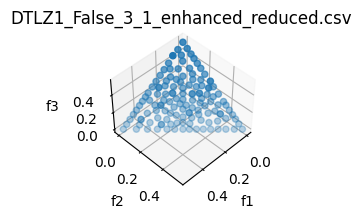

In [ ]:
seed_arr = [1]
for seed in seed_arr:

    # This is for 2 objectives.
    n_funcs = 3
    total_evals = 50000
    n_final = 120

    problem_arr = ["DTLZ1"]

    inverted_flag_arr = [False]

    n_vars_arr = [7]

    ref_points = [[1,1,1]]

    '''
    # This is for 2 objectives.
    n_funcs = 2
    total_evals = 40000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP1","IMOP2","IMOP3",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [6,11,11,11,11,11,21,
                  6,11,11,11,11,11,21,
                  10,10,10,
                  24,24,24,24,24,24,24,24,24,
                  24,24,24,24,24,24,24,24,24]

    ref_points = [[1,1],[2,2],[2,2],[2,2],[2,2],[2,2],[1,21],
                 [1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[0.1,-10],
                 [1.2,1.2],[1.2,1.2],[1.5,1.2],
                 [3,5],[3,5],[3,5],[3,5],[3,5],[3,5],[3,5],[3,5],[3,5],
                 [1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1]]
    '''

    '''
    # This is for 3 objectives.
    n_funcs = 3
    total_evals = 50000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP4","IMOP5","IMOP6","IMOP7","IMOP8",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "VIE1","VIE2","VIE3"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True,
                        False,False,False]

    n_vars_arr = [7,12,12,12,12,12,22,
                  7,12,12,12,12,12,22,
                  10,10,10,10,10,
                  26,26,26,26,26,26,26,26,26,
                  26,26,26,26,26,26,26,26,26,
                  2,2,2]

    ref_points = [[1,1,1],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[2,2,2],[1,1,21],
                 [1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[0.1,0.1,-10],
                 [1.2,1.2,1.2],[1,1,2],[1.2,1.2,1.2],[1.2,1.2,1.2],[1.2,1.2,3.2],
                 [3,5,7],[3,5,7],[3,5,7],[3,5,7],[3,5,7],[3,5,7],[3,5,7],[3,5,7],[3,5,7],
                 [1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],
                 [4,5,4],[5,-15,-11],[10,18,1]]
    '''

    '''
    # This is for 5 objectives.
    n_funcs = 5
    total_evals = 70000
    n_final = 126

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [9,14,14,14,14,14,24,
                  9,14,14,14,14,14,24,
                  30,30,30,30,30,30,30,30,30,
                  30,30,30,30,30,30,30,30,30]

    ref_points = [[1,1,1,1,1],[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2],[2,2,2,2,2],[1,1,1,1,21],
                 [1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[0.1,0.1,0.1,0.1,-10],
                 [3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],[3,5,7,9,11],
                 [1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]
    '''

    '''
    # This is for 7 objectives.
    n_funcs = 7
    total_evals = 90000
    n_final = 210

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [11,16,16,16,16,16,26,
                  11,16,16,16,16,16,26,
                  34,34,34,34,34,34,34,34,34,
                  34,34,34,34,34,34,34,34,34]
    '''


    if len(problem_arr) == len(n_vars_arr) and len(problem_arr) == len(inverted_flag_arr):
        print('All good to start, validation complete')

    total_different_experiments = len(problem_arr)
    print('Total experiments: ', total_different_experiments)


    for current in range(total_different_experiments):

        current = current

        # Problem Variables.
        problem = problem_arr[current]
        inverted_flag = inverted_flag_arr[current]
        n_vars = n_vars_arr[current]

        ind_main = HV(ref_point=ref_points[current])

        # Algorithm Variables.
        n_initial = int(n_final/4)
        epsilon = 1.8
        q = 0.5
        nds_max = n_final * 3
        std_threshold = 0.1
        replace_tw = 4
        replace_pct = 0.5
        # MUST BE TRUE
        replace_flag = True

        pair_potential_function = 'COU'

        start_time = time.time()
        np.random.seed(seed)

        variable_threshold = threshold_of_every_variable(std_threshold, n_vars, problem)
        file_to_save = np.empty([n_vars + n_funcs + 1])
        solutions = initial_solutions(problem, n_initial, n_vars)
        evaluations = evaluate_function(problem, solutions, n_funcs, n_vars, inverted_flag)

        solutions, evaluations, layers = layered_array(solutions, evaluations, n_vars, n_funcs, n_initial)
        weights = selection_weights(q,n_initial)
        NDS = initial_non_dominated(solutions, evaluations, n_vars, n_funcs, nds_max, pair_potential_function)

        solutions, evaluations = PPF_sorting(solutions, evaluations, layers, NDS, n_initial, n_vars, n_funcs)

        fn_evals = n_initial
        gen = 1

        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = update_non_dominated(NDS, solutions, evaluations, n_vars, n_funcs, n_final, pair_potential_function)
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))


        while fn_evals < total_evals:

            if fn_evals > total_evals * 0.8:
                epsilon = 1.8 / 2
                replace_flag = False

            solutions_to_modify = obtain_solutions_to_modify(solutions, weights, n_vars)

            choices, stalled = inteligent_select_dim_std(problem, solutions, n_vars, variable_threshold)

            if len(choices) > 0:
                number_to_modify = number_of_vars_to_modify(choices, n_initial, n_funcs)
                modify_variables = vars_to_modify_func(choices, n_initial, number_to_modify)
            else:
                number_to_modify = number_of_vars_to_modify(stalled, n_initial, n_funcs)
                modify_variables = vars_to_modify_func(stalled, n_initial, number_to_modify)

            std_matrix = std_matrix_func(solutions, solutions_to_modify, modify_variables, n_initial, n_vars, epsilon)
            new_solutions = new_solutions_func(solutions_to_modify, std_matrix, n_initial, n_vars)
            new_evaluations = evaluate_function(problem, new_solutions, n_funcs, n_vars, inverted_flag)
            fn_evals = fn_evals + n_initial

            solutions = np.concatenate((solutions, new_solutions))
            evaluations = np.concatenate((evaluations, new_evaluations))

            solutions, evaluations, layers = layered_array(solutions, evaluations, n_vars, n_funcs, n_initial)

            NDS = update_non_dominated(NDS, solutions, evaluations, n_vars, n_funcs, nds_max, pair_potential_function)
            solutions, evaluations = PPF_sorting(solutions, evaluations, layers, NDS, n_initial, n_vars, n_funcs)

            if (((gen)%replace_tw) == 0) and (len(stalled) > 0) and (replace_flag):
                solutions, evaluations = new_replace_mechanism(stalled, NDS, n_vars, n_funcs, n_initial, replace_pct, problem, inverted_flag)
                fn_evals = fn_evals + n_initial * replace_pct

            gen = gen + 1


        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = update_non_dominated(NDS, solutions, evaluations, n_vars, n_funcs, n_final, pair_potential_function)
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))



        tile_of_file = problem + "_" + str(inverted_flag) + "_" + str(n_funcs) + "_" + str(seed) + ".csv"
        file_to_save = np.delete(file_to_save,0,0)
        df = pd.DataFrame(file_to_save)
        tile_of_file = problem + "_" + str(inverted_flag) + "_" + str(n_funcs) + "_" + str(seed) + ".csv"
        df.to_csv("/content/drive/MyDrive/Final_Results/GI_MOACOR/" + tile_of_file)


        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Experiment Completed: ', current + 1)
        print("Elapsed time: ", elapsed_time)
        hyper_volume = ind_main(output_at_the_moment[:,n_vars:n_vars+n_funcs])
        print('HV', hyper_volume)
        plot_3d(output_at_the_moment[:,n_vars:n_vars+n_funcs], tile_of_file)